In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from geopy.distance import geodesic

## 实际时刻表

In [2]:
shike = pd.read_excel('C:\intern\data\docs_updated\时刻表\shike.xlsx')
shike_sorted = shike.sort_values(by=['路线', '车次id', '站序'])
shike_sorted

,路线,车次id,站序,站点,时间,经度,纬度
2303,Y1,411,1,临江地铁站,07:40:00,118.672528,32.062686
2304,Y1,411,2,云驰街,07:46:00,118.649936,32.043162
2305,Y1,412,1,临江地铁站,07:50:00,118.672528,32.062686
2306,Y1,412,2,云驰街,07:56:00,118.649936,32.043162
2307,Y1,413,1,临江地铁站,07:55:00,118.672528,32.062686
...,...,...,...,...,...,...,...
685,Y9,132,5,行知路·雨合路（浦潮接驳站）,16:25:00,118.613390,32.029400
686,Y9,132,6,光电科技园,16:27:00,118.609818,32.023728
687,Y9,132,7,耀华,16:30:00,118.620302,32.022355
688,Y9,132,8,网易数字产业基地,16:31:00,118.621790,32.022580


## 对应bus_id 和 gps_sn

* 可能存在gps_info.xlsx中bus_id并不存在的情况

In [3]:
checi = pd.read_excel('C:/intern/data/docs_updated/时刻表/checi.xlsx')
gps = pd.read_excel('C:/intern/data/docs_updated/GPS/gps_info.xlsx')
bus = pd.read_excel('C:/intern/data/docs_updated/GPS/bus_info.xlsx')
duiying = pd.read_excel('C:/intern/data/docs_updated/时刻表/duiying.xlsx')

In [4]:
gps.columns

Index(['id', 'create_time', 'update_time', 'delete_time', 'create_user_id',
       'update_user_id', 'gps_sn', 'gps_name', 'bus_id'],
      dtype='object')

In [5]:
# 确认bus_id范围
bus.columns

Index(['id', 'create_time', 'update_time', 'delete_time', 'bus_user_phone',
       'bus_user_name', 'bus_plate', 'seat_number'],
      dtype='object')

In [6]:
# 真实存在的bus_id
real_id = bus.id.value_counts().index
real_id

Int64Index([  1,  70,  79,  78,  77,  76,  75,  74,  73,  72,  71,  69,  57,
             68,  67,  66,  65,  64,  63,  62,  61,  60,  80,  81,  82,  83,
            105, 104, 103, 102, 101, 100,  99,  96,  95,  94,  93,  92,  91,
             90,  89,  87,  86,  85,  84,  59,  56,   2,  13,  24,  23,  22,
             21,  20,  19,  18,  17,  16,  12,  55,  11,  10,   9,   8,   7,
              6,   5,   4,   3,  25,  26,  27,  28,  52,  51,  50,  49,  48,
             47,  46,  44,  43,  42,  41,  40,  39,  38,  34,  33,  31,  30,
             29, 106],
           dtype='int64')

#### 一辆车是否可能有不同的gps_sn? 检查duplicates

In [7]:
gps.bus_id.value_counts()

\N    21
-1    14
0     11
4      1
41     1
      ..
59     1
56     1
78     1
81     1
61     1
Name: bus_id, Length: 65, dtype: int64

* \N, -1, 0 都不在real_id的范围, 去除

In [8]:
gps = gps[(gps.bus_id!='\\N') & (gps.bus_id!='-1') & (gps.bus_id!='0')]

In [9]:
gps.bus_id.value_counts()

4     1
70    1
75    1
91    1
92    1
     ..
56    1
78    1
81    1
89    1
61    1
Name: bus_id, Length: 62, dtype: int64

* 已去除invalid id， 不存在duplicates了

#### 是否gps数据都是相关车辆的？提取gps_sn对应的bus_id id1, bus_info中的bus_id id2, 找到id in id1 but not in id2


In [10]:
gps.columns

Index(['id', 'create_time', 'update_time', 'delete_time', 'create_user_id',
       'update_user_id', 'gps_sn', 'gps_name', 'bus_id'],
      dtype='object')

In [11]:
id1 = gps.bus_id.unique()
id1

array(['4', '7', '33', '34', '26', '28', '29', '24', '30', '22', '31',
       '57', '55', '47', '102', '68', '46', '95', '106', '104', '84',
       '93', '85', '44', '59', '56', '78', '81', '89', '65', '83', '80',
       '69', '75', '91', '92', '43', '63', '76', '41', '96', '50', '82',
       '86', '72', '99', '70', '94', '62', '67', '52', '66', '73', '90',
       '101', '100', '74', '60', '103', '23', '79', '61'], dtype=object)

In [12]:
id2 = bus.id.unique()
id2

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  33,  34,  38,  39,  40,  41,  42,  43,  44,  46,
        47,  48,  49,  50,  51,  52,  55,  56,  57,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  89,
        90,  91,  92,  93,  94,  95,  96,  99, 100, 101, 102, 103, 104,
       105, 106], dtype=int64)

In [13]:
gps_not4bus_id = []
for i in id1:
    if int(i) not in id2:
        gps_not4bus_id.append(i)
gps_not4bus_id        

[]

* 都是车辆相关的gps_info

#### 哪些车辆找不到gps_sn?

In [14]:
bus_noGPS_id = []
for i in id2:
    if str(i) not in id1:
        bus_noGPS_id.append(i)
bus_noGPS_id       

[1,
 2,
 3,
 5,
 6,
 8,
 9,
 10,
 11,
 12,
 13,
 16,
 17,
 18,
 19,
 20,
 21,
 25,
 27,
 38,
 39,
 40,
 42,
 48,
 49,
 51,
 64,
 71,
 77,
 87,
 105]

In [15]:
len(bus_noGPS_id )

31

In [16]:
# check 
len(bus_noGPS_id) == len(id2)-len(id1)

True

* 31辆车没有GPS数据

#### 导出无GPS 数据车辆

In [17]:
#无GPS数据车辆
bus_noGPS_df = bus[bus['id'].isin(bus_noGPS_id)]

In [18]:
#导出
bus_noGPS_df.to_excel("C:/intern/data/result/bus_gps_nan.xlsx") 

## GPS data

#### 读取

In [19]:
gps_info_up = pd.read_excel('C:\intern\data\docs_updated\GPS\April_up.xlsx')

In [20]:
gps_info_up.columns

Index(['序号', 'gps串号', 'gps状态', '经度', '纬度', '接收时间', '速度', '方向', '电源状态'], dtype='object')

In [21]:
gps_info_up.sample(2)

,序号,gps串号,gps状态,经度,纬度,接收时间,速度,方向,电源状态
589246,6734907,868773051027640,1,118.709585,32.156152,2022-04-10 20:37:47,0,172,1
613668,6759329,868773050944811,1,118.674045,32.085526,2022-04-11 10:24:33,22,208,1


In [22]:
#查看gps_info_up的接收时间 datatype， 需要datetime
type(gps_info_up['接收时间'].values[0])

str

In [23]:
#新增‘接收日期’column
gps_info_up['接收日期'] = gps_info_up['接收时间'].str[0:10]

In [24]:
gps_info_up['接收时间']= pd.to_datetime (gps_info_up ['接收时间'])

In [25]:
type(gps_info_up['接收时间'].values[0])

numpy.datetime64

In [26]:
gps_info_up.sample(2)

,序号,gps串号,gps状态,经度,纬度,接收时间,速度,方向,电源状态,接收日期
123354,6269015,868773050939928,1,118.656448,32.041451,2022-04-02 14:28:40,0,285,1,2022-04-02
496003,6641664,868773050945123,1,118.722188,32.151677,2022-04-08 20:33:50,0,268,1,2022-04-08


In [27]:
#查看available gps_sn
gps_sn_available_up = gps_info_up['gps串号'].unique()
gps_sn_available_up

array([868773050940116, 868773050937062, 868773050937088, 868773051025099,
       868773050941585, 868773050940165, 868773050940066, 868773050942237,
       868773050943359, 868773050934630, 868773050945404, 868773051024381,
       868773050942377, 868773050941288, 868773050942286, 868773050934655,
       868773051026642, 868773050942294, 868773050939910, 868773050933251,
       868773051027640, 868773050939902, 868773050939936, 868773050939928,
       868773051026998, 868773050939993, 868773051024779, 868773050939985,
       868773050939506, 868773050939555, 868773050940652, 868773050939456,
       868773050941528, 868773050939449, 868773051024928, 868773050939464,
       868773051022153, 868773050944795, 868773050944811, 868773050929010,
       868773050877235, 868773050864423, 868773050654550, 868773050646382,
       868773050941403, 868773050941569, 868773051027004, 868773050945388,
       868773051026626, 868773050938227, 868773050945123, 868773050939423,
       868773050945768, 8

In [28]:
#确认available gps_sn都有对应的info
gps_sn_list = gps.gps_sn.unique()
for each in gps_sn_available_up:
    if str(each) not in gps_sn_list:
        print('This is a new GPS device: ', each)

In [29]:
#抽取一个gps_sn
#current_gps_sn = '868773050877235'
current_gps_sn = '868773050943359'
current_data = gps_info_up[gps_info_up['gps串号']==int(current_gps_sn)]
current_data = current_data.sort_values(by='接收时间')

In [30]:
#查看这个gps_sn的可用日期
current_gps_dates = current_data['接收日期'].unique()
current_gps_dates

array(['2022-04-01', '2022-04-02', '2022-04-03', '2022-04-04',
       '2022-04-05', '2022-04-06', '2022-04-07', '2022-04-08',
       '2022-04-09', '2022-04-10', '2022-04-11', '2022-04-12',
       '2022-04-13', '2022-04-14'], dtype=object)

In [31]:
#抽取一个日期
pick_date = '2022-04-01'
pick_data = current_data[current_data['接收日期']==pick_date]

In [32]:
pick_data.sample(5)

,序号,gps串号,gps状态,经度,纬度,接收时间,速度,方向,电源状态,接收日期
29320,6174981,868773050943359,1,118.678614,32.115014,2022-04-01 11:38:03,34,129,1,2022-04-01
15325,6160986,868773050943359,1,118.690833,32.080189,2022-04-01 09:15:28,53,133,1,2022-04-01
48421,6194082,868773050943359,1,118.684954,32.084656,2022-04-01 15:53:18,36,103,1,2022-04-01
60398,6206059,868773050943359,1,118.687127,32.109968,2022-04-01 18:17:46,27,44,1,2022-04-01
16307,6161968,868773050943359,1,118.691287,32.080037,2022-04-01 09:23:56,53,312,1,2022-04-01


In [33]:
#以接收时间为X轴，以[1]*len()为y轴，画出点线图，check GPS接收频率
x = pick_data['接收时间'].values[0:20]
y = [1]*len(x)


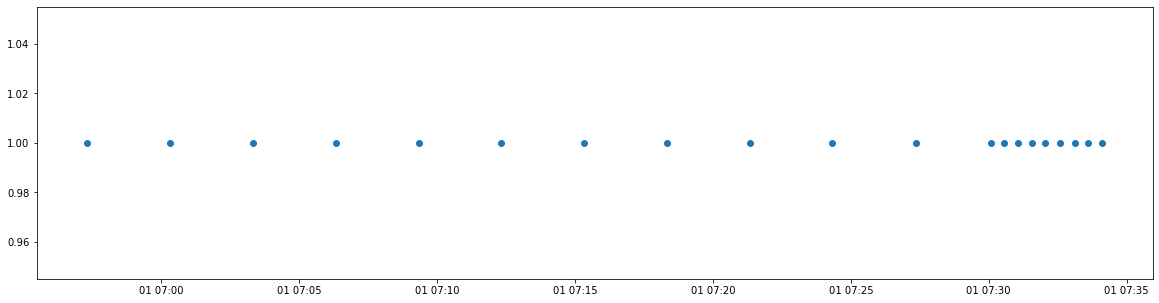

In [34]:
plt.figure(figsize= (20,5))
plt.scatter(x, y)

In [35]:
# 导入GPS有问题的车辆数据
bus_wrong_gps_df = pd.read_excel('C:/intern/data/docs_updated/GPS/GPS数据问题.xlsx', sheet_name='gps数据间隔超过1分钟车辆')

In [36]:
bus_wrong_gps_df.columns

Index(['gps_sn', '车牌号', 'gps时间间隔(秒)', 'Unnamed: 3'], dtype='object')

In [37]:
bus_wrong_gps_df

,gps_sn,车牌号,gps时间间隔(秒),Unnamed: 3
0,868773050877235,苏AJ7270,150.166667,上午7:30或7:50以前间隔超过一分钟
1,868773050646382,苏AJ7977,150.166667,NaN
2,868773050943359,苏AJ7298,150.000000,NaN
3,868773050654550,苏AJ7980,150.000000,NaN


In [38]:
# check data type
type(bus_wrong_gps_df['gps_sn'].values[0])

numpy.int64

In [39]:
# check data type
type(gps_info_up['gps串号'].values[0])

numpy.int64

In [40]:
# 去除异常值
gps_info_up_cleaned = gps_info_up[~gps_info_up['gps串号'].isin(bus_wrong_gps_df['gps_sn'].values)]

In [41]:
len(gps_info_up['gps串号'].unique())

59

In [42]:
len(gps_info_up_cleaned['gps串号'].unique())

55

## 实际运营车辆情况

In [43]:
#valid gps_sn
gps_info_up_cleaned['gps串号'].unique()

array([868773050940116, 868773050937062, 868773050937088, 868773051025099,
       868773050941585, 868773050940165, 868773050940066, 868773050942237,
       868773050934630, 868773050945404, 868773051024381, 868773050942377,
       868773050941288, 868773050942286, 868773050934655, 868773051026642,
       868773050942294, 868773050939910, 868773050933251, 868773051027640,
       868773050939902, 868773050939936, 868773050939928, 868773051026998,
       868773050939993, 868773051024779, 868773050939985, 868773050939506,
       868773050939555, 868773050940652, 868773050939456, 868773050941528,
       868773050939449, 868773051024928, 868773050939464, 868773051022153,
       868773050944795, 868773050944811, 868773050929010, 868773050864423,
       868773050941403, 868773050941569, 868773051027004, 868773050945388,
       868773051026626, 868773050938227, 868773050945123, 868773050939423,
       868773050945768, 868773050939415, 868773050937054, 868773050940405,
       868773050945289, 8

In [44]:
#抽取一个gps_sn
this_sn = '868773050940116'

#### 获得相对应GPS数据


In [45]:
this_data = gps_info_up_cleaned[gps_info_up_cleaned['gps串号']==int(this_sn)]
this_data = this_data.sort_values(by='接收时间')


In [46]:
this_data.sample(2)

,序号,gps串号,gps状态,经度,纬度,接收时间,速度,方向,电源状态,接收日期
544647,6690308,868773050940116,1,118.713325,32.168419,2022-04-09 19:34:17,0,209,1,2022-04-09
75169,6220830,868773050940116,1,118.720388,32.146383,2022-04-01 20:52:19,0,53,1,2022-04-01


#### 获得车辆信息

In [47]:
this_bus_id = int(gps[gps['gps_sn']==this_sn].bus_id)
this_bus_plate = bus[bus['id']==this_bus_id].bus_plate.values[0] 

In [48]:
this_bus_plate

'苏AE1928'

#### 获得车次&站点信息

In [49]:
this_checi_linked = duiying[duiying['车牌号']==this_bus_plate]['车次id'].values
this_zhandian_linked = pd.DataFrame(columns=['路线', '车次id', '站序', '站点', '时间', '经度', '纬度'])
for checi_ in this_checi_linked:
    this_zhandian_linked = this_zhandian_linked.append(shike[shike['车次id']==checi_])

C:\Users\10157\AppData\Local\Temp\ipykernel_17332\3410247740.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  this_zhandian_linked = this_zhandian_linked.append(shike[shike['车次id']==checi_])
C:\Users\10157\AppData\Local\Temp\ipykernel_17332\3410247740.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  this_zhandian_linked = this_zhandian_linked.append(shike[shike['车次id']==checi_])


In [50]:
#possible车次
this_checi_linked

array([164, 174], dtype=int64)

In [51]:
#possible站点
this_zhandian_linked

,路线,车次id,站序,站点,时间,经度,纬度
828,Y16,164,1,星火路地铁站,07:45:00,118.70489,32.16273
829,Y16,164,2,云驰街,08:30:00,118.649936,32.043162
830,Y16,164,3,网易数字产业基地,08:39:00,118.62179,32.02258
831,Y16,164,4,耀华,08:40:00,118.620302,32.022355
832,Y16,164,5,光电科技园,08:45:00,118.609818,32.023728
833,Y16,164,6,行知路,08:50:00,118.61339,32.0294
888,Y16,174,1,行知路,17:17:00,118.61339,32.0294
889,Y16,174,2,光电科技园,17:20:00,118.609818,32.023728
890,Y16,174,3,耀华,17:23:00,118.620302,32.022355
891,Y16,174,4,网易数字产业基地,17:24:00,118.62179,32.02258


#### 获得车辆活动日期

In [52]:
# dates at which signals collected
this_signal_dates = this_data['接收日期'].unique()

In [53]:
this_signal_dates

array(['2022-04-01', '2022-04-02', '2022-04-06', '2022-04-07',
       '2022-04-08', '2022-04-09', '2022-04-10', '2022-04-11',
       '2022-04-12', '2022-04-13', '2022-04-14'], dtype=object)

#### 确定所有的首尾站组合

In [54]:
#valid start stations
this_valid_stations = this_zhandian_linked[this_zhandian_linked['站序']==1]
this_station_start = this_valid_stations['站点'].values
this_checi_start = this_valid_stations['车次id'].values
this_time_start_true = this_valid_stations['时间'].values

#valid end stations
this_last_valid = this_zhandian_linked.groupby('车次id').last()
this_last_valid = this_last_valid.reset_index()
this_station_end = this_last_valid['站点'].values
this_checi_end = this_last_valid['车次id'].values
this_time_end_true = this_last_valid['时间'].values

#### 判断车次车辆是否一致

评估1. 在首站前后1分钟，且1km之内，GPS接收次数不为0；在末站前后5分钟，且5km之内，GPS接收次数不为0。两个条件满足之一即可。

评估2. 该车次首末站时间段内是否经过首末站。假设公交车行驶速度30km/h，即0.5km/min； 假设GPS数据迟钝30s，即0.5min； 假设GPS定位误差200m  -是否经过首末站标准：范围0.27km距离

综合评估 = 评估1 + 评估2

##### 到达末站时间点以后的行驶时间不能超过20min

If当前GPS收集时间 - 时刻表末尾站时间 > 20 

-> then评估2降为0

In [55]:
#计算位置和站点的距离
def distance(curr_long, curr_lat, station_long, station_lat):
    curr_ = (curr_lat, curr_long)
    station_ = (station_lat, station_long)
 
    return (geodesic(curr_, station_).km)
    #return ((curr_long-station_long)**2+(curr_lat-station_lat)**2)**(1/2)
    #return (abs(curr_long-station_long)+abs(curr_lat-station_lat))

In [56]:
def find_possible_routes(dates, eval_df, data):
    
    for eachD_id in range(len(dates)):
        
        #data at this date
        try_data = data[data['接收日期']==dates[eachD_id]]
        
        for i in range(len(this_station_start)):
            current_station_row_start = this_valid_stations.iloc[i]
            current_station_row_end = this_last_valid.iloc[i]

            current_luxian = current_station_row_start['路线']
            current_checi = current_station_row_start['车次id']
            current_zhandian_start = current_station_row_start['站点']
            current_zhandian_end = current_station_row_end['站点']
            current_start_time_true = current_station_row_start['时间']
            current_end_time_true = current_station_row_end['时间']
            
            
            
            
            #是否合格
            satisfy_start= 0
            satisfy_end = 0
            check_standard2 = 0
            
            #接收GPS次数
            c_start = 0
            c_end = 0
            
            #iterate signals to find valid counts
            for index1, row1 in try_data.iterrows():
                
                date_ = row1['接收日期']
                dt1 = row1['接收时间']
                time_format = "%Y-%m-%d %H:%M:%S"
                
                time_supposed_start = date_+' '+current_station_row_start['时间']
                time_supposed_end = date_+' '+current_station_row_end['时间']
                time_supposed_start = datetime.strptime(time_supposed_start, time_format)
                time_supposed_end = datetime.strptime(time_supposed_end, time_format)
                
                time_after_end = (dt1 - time_supposed_end).total_seconds() / 60
                
                """
                if time_after_end>100:
                    #print(time_after_end)
                    check_standard2 = 0
                """
                
                #离起点距离
                dist_to_start = distance(row1['经度'], row1['纬度'], current_station_row_start['经度'], current_station_row_start['纬度'])
                #离终点距离
                dist_to_end = distance(row1['经度'], row1['纬度'], current_station_row_end['经度'], current_station_row_end['纬度'])
                
                
                
                #距离起点1km内
                if dist_to_start<=1:
                #if (abs(row1['经度']-current_station_row_start['经度'])+abs(row1['纬度']-current_station_row_start['纬度'])<=0.001):
                    
                    
                    #abs_diff = abs((dt2 - dt1) // timedelta(minutes=1))
                    time_diff = (time_supposed_start - dt1).total_seconds() / 60
                    abs_diff = abs(time_diff)
                    
                    #print('..')
                    #前后一分钟
                    if (abs_diff<=1):
                        c_start += 1
                    
                    #到达预计首站出发时间, GPS可能有30s延迟
                    if time_diff<=-0.5:
                        
                        #经过始发站
                        if distance(row1['经度'], row1['纬度'], current_station_row_start['经度'], current_station_row_start['纬度'])<=0.2:
                        #if (abs(row1['经度']-current_station_row_start['经度'])+abs(row1['纬度']-current_station_row_start['纬度'])<=0.0003):
                            
                            check_standard2 = 1
                            
                
                #距离终点5km内
                elif dist_to_end<=5:
                #elif  (abs(row1['经度']-current_station_row_end['经度'])+abs(row1['纬度']-current_station_row_end['纬度'])<=0.005):
                    
                    time_diff = (time_supposed_end - dt1).total_seconds() / 60
                    abs_diff = abs(time_diff)
                    
                    #print('.. ..')
                    #前后五分钟
                    if (abs_diff<=5):
                        #print('...yes')
                        c_end += 1
                    
                    #到达预计终点站到达时间, GPS可能有30s延迟
                    if time_diff>=-0.5:
            
                        #经过终点站
                        if distance(row1['经度'], row1['纬度'], current_station_row_end['经度'], current_station_row_end['纬度'])<=0.2:
                        #if (abs(row1['经度']-current_station_row_end['经度'])+abs(row1['纬度']-current_station_row_end['纬度'])<=0.0003):
                            if check_standard2: 
                                check_standard2=1
                                pass_end = 1
                            else:
                                check_standard2=0
                        else:
                            check_standard2=0
                
                #standard 1 validation
                if c_start>0: satisfy_start = 1
                if c_end>0: satisfy_end = 1
                    
                #check standard 1
                check_standard1 = satisfy_start | satisfy_end
                #if satisfy_start | satisfy_end: check_standard1=1
                
                #overalll evaluation
                overall_eval = check_standard1 + check_standard2
                
            #add record to the eval_df
            eval_df.loc[len(eval_df.index)] = [dates[eachD_id], current_luxian, current_checi, current_zhandian_start, c_start, satisfy_start, current_zhandian_end, c_end, satisfy_end, check_standard1, check_standard2, overall_eval]

In [57]:
eval_df = pd.DataFrame(columns=['日期', '路线', '车次id', '起点', '起点接收次数', '起点合格', '终点', '终点接收次数', '终点合格', '评估1', '评估2', '综合评估'])
find_possible_routes(this_signal_dates, eval_df, this_data)
print('gps_sn: ', this_sn)
print('车牌: ', this_bus_plate)
print('bus_id: ', this_bus_id)

eval_df

gps_sn:  868773050940116
车牌:  苏AE1928
bus_id:  55


,日期,路线,车次id,起点,起点接收次数,起点合格,终点,终点接收次数,终点合格,评估1,评估2,综合评估
0,2022-04-01,Y16,164,星火路地铁站,4,1,行知路,20,1,1,1,2
1,2022-04-01,Y16,174,行知路,3,1,星火路地铁站,24,1,1,0,1
2,2022-04-02,Y16,164,星火路地铁站,4,1,行知路,20,1,1,1,2
3,2022-04-02,Y16,174,行知路,6,1,星火路地铁站,21,1,1,0,1
4,2022-04-06,Y16,164,星火路地铁站,4,1,行知路,20,1,1,1,2
5,2022-04-06,Y16,174,行知路,7,1,星火路地铁站,24,1,1,0,1
6,2022-04-07,Y16,164,星火路地铁站,4,1,行知路,20,1,1,1,2
7,2022-04-07,Y16,174,行知路,5,1,星火路地铁站,33,1,1,0,1
8,2022-04-08,Y16,164,星火路地铁站,4,1,行知路,20,1,1,1,2
9,2022-04-08,Y16,174,行知路,6,1,星火路地铁站,25,1,1,0,1


#### 检测车辆轨迹

1. 查找1-3分钟内无移动GPS数据 
2. 定位这个位置
3. 定位离这个位置最近的站点
3. 通过时刻表找到最近站点的所有乘车时刻t_shike
5. 遍历t_shike,计算其与收到3条GPS信号的时候的时间差 
6. （假设5分钟为合理范围）找到合理时间点对应的车站


假设20s一条数据，1-3分钟须有 3-9条数据

In [58]:
#各个站点gps定位
site_gps = pd.read_excel('C:/intern/data/docs_updated/路线站点信息/site_gps.xlsx')

In [59]:
len(site_gps)

120

In [60]:
#只想知道站点位置，去除路线column，再去重
#site_gps.drop ('Y路线', axis=1, inplace=True)
#site_gps.drop_duplicates(keep = False, inplace = True)

In [61]:
len(site_gps)

120

In [62]:
site_gps.sample(10)

,Y路线,站点,经度,纬度
60,Y14,云驰街,118.649936,32.043162
10,Y22,江苏省产业技术研究院,118.650760,32.033867
82,Y18,高新路.新科三路公交站,118.723728,32.180200
65,Y16,光电科技园,118.609818,32.023728
23,Y5,耀华,118.620302,32.022355
9,Y22,临江,118.672528,32.062686
72,Y17,创智大厦,118.703310,32.161130
41,Y9,行知路雨合路,118.613390,32.029400
70,Y17,云驰街,118.649936,32.043162
76,Y18,研发大厦,118.719410,32.163330


In [63]:
shike.sample(5)

,路线,车次id,站序,站点,时间,经度,纬度
1154,Y18,215,6,高科一路.新科二路公交站,08:54:00,118.729140,32.179569
78,Y4,12,6,临江地铁站,08:36:00,118.672528,32.062686
1241,Y18,224,3,高新路.祥和路,09:34:00,118.722830,32.174618
281,Y4,46,1,临江地铁站,16:18:00,118.672528,32.062686
1549,Y19,256,5,香溢紫郡1期.高新区总站北,08:58:00,118.710321,32.186430


#### 最近的两个站点位置距离多少km?

In [64]:
smallest_distance = float('inf')
pairs = []
for index1, row1 in site_gps.iterrows():
    for index2, row2 in site_gps.iterrows():
        if index1!=index2:
            dist_ = distance(row1['经度'], row1['纬度'], row2['经度'], row2['纬度'])
            if (dist_!=0) & (dist_<=(smallest_distance)):
                smallest_distance = dist_
                pairs.append([row1['站点'], row2['站点']])
                
print('Nearest two stations are: ', pairs[len(pairs)-1])
print('Their distance is ', smallest_distance)

Nearest two stations are:  ['高新路.桐雨路', '高新路.祥和路']
Their distance is  0.016850258711161564


In [65]:
zhandian_route = pd.DataFrame(columns=['站点','路线'])
zhandians = shike['站点'].unique()
for zd in zhandians:
    possible_luxian = []
    route_df = shike[shike['站点']==zd]
    for index, row in route_df.iterrows():
        possible_luxian.append(row['路线'])
    
    possible_luxian = list(set(possible_luxian))
    zhandian_route.loc[len(zhandian_route)] = [zd, possible_luxian]
zhandian_route

,站点,路线
0,成贤地铁站,"[Y3, Y18]"
1,南京工业大学,[Y3]
2,镇南河路（雨发建设集团门口）,[Y3]
3,万汇城（浦滨路）,[Y3]
4,膜园,"[Y5, Y6, Y4, Y9, Y13, Y10, Y3]"
...,...,...
80,南京集成电路大学,[Y21]
81,工大地铁站北公交站台,[Y21]
82,江苏省产业技术研究院,[Y22]
83,韦恩,"[Y1, Y2]"


In [66]:
#find nearest station
def possible_nearest_station(site_df, shike_df, this_long, this_lat, time, date):
    time_format = "%Y-%m-%d %H:%M:%S"
    min_dist = float('inf')
    res = 'Not Found'

    for index, row in site_df.iterrows():
        site_long = row['经度']
        site_lat = row['纬度']
        dist = distance(this_long, this_lat, site_long, site_lat)
        if dist < min_dist: 
            
            min_dist = dist
            res = row['站点']
            
            """
            shike_picked = shike_df[(shike_df['经度']==site_long) & (shike_df['纬度']==site_lat)]
            
            for index2, row2 in shike_picked.iterrows():
                t_supposed = date+' '+ row2['时间']
                t_supposed = datetime.strptime(t_supposed, time_format)
                abs_diff = abs((t_supposed - time).total_seconds() / 60)

                if abs_diff<5: 
                    min_dist = dist
                    res = row2['站点']
            """        
          
            
    return res, min_dist
        

In [67]:
def find_possible_stations(dates, data, pos_df):
    for eachD_id in range(len(dates)):
        
        #data at this date
        try_data = data[data['接收日期']==dates[eachD_id]]
        
        #position info
        last_longitude = 0
        last_latitude = 0 
        count_stay = 0
        
        #iterate signals
        for index1, row1 in try_data.iterrows():
            
            #position unchanged 
            if (row1['经度']==last_longitude) | (row1['纬度']==last_latitude):
                                            #& (row1['纬度']==last_latitude)
                count_stay += 1
                
                #check duration
                if count_stay ==2:
                    nearest_, distance = possible_nearest_station(site_gps, shike, last_longitude, last_latitude, row1['接收时间'],dates[eachD_id])
                    
                    route_relate = zhandian_route[zhandian_route['站点'].str.contains(nearest_)]['路线'].values
                    if len(route_relate):
                        for i in route_relate[0]:
                            pos_df.loc[len(pos_df.index)] = [dates[eachD_id],row1['接收时间'], last_longitude, last_latitude, nearest_, distance, i]
                    else:
                        pos_df.loc[len(pos_df.index)] = [dates[eachD_id],row1['接收时间'], last_longitude, last_latitude, nearest_, distance, 'unknown']
                    
                elif count_stay>9:
                    #pos.pop()
                    pos_df.drop(pos_df.tail(1).index,inplace=True)
                    count_stay = 0
                    
            else:
                count_stay = 0
                last_longitude = row1['经度']
                last_latitude = row1['纬度']
            
                
                
            
            

In [68]:
luxian_s = site_gps['Y路线'].unique()
route_sites_num = {}
for each in luxian_s:
    c = len(site_gps[site_gps['Y路线']==each])
    route_sites_num[each] = c    
route_sites_num['unknown'] = 100
route_sites_num['Y20'] = 18
route_sites_num['Y21'] = 4
#route_sites_num

In [113]:
def tract_route(this_checi_linked):
    #所有停留的GPS数据
    pos_df = pd.DataFrame(columns=['日期','具体时间', '停留经度','停留纬度', '最近站点','距离', '所属路线'])
    find_possible_stations(this_signal_dates, this_data, pos_df)

    #去重
    pos_df2 = pos_df.drop_duplicates(subset=['最近站点','所属路线','日期'])

    #分析
    pos_df2['所属路线_counts'] = 0
    pos_df2['路线对应站点_counts'] = 0
    for index, row in pos_df2.iterrows():
        pos_df2.at[index,'所属路线_counts'] = get_counts(row['日期'], row['所属路线'], pos_df2)
        luxian = row['所属路线']
        """
        if (luxian=='Y21') |(luxian=='Y22'):
            luxian='unknown'
        """
        pos_df2.at[index,'路线对应站点_counts'] = route_sites_num[luxian]

    pos_df2['路线匹配度'] = pos_df2['所属路线_counts']/pos_df2['路线对应站点_counts']
    match = 0.5
    pos_df2['匹配'] = (pos_df2['路线匹配度']>=match)
    pos_df2['匹配车次'] = 0
    pos_df2['匹配车次'] = pos_df2['所属路线'].map(lambda x: get_valid_checi(x, this_checi_linked))
    
    return pos_df2


In [75]:
def get_counts(date, luxian, df):
    return len(df[(df['所属路线']==luxian)&(df['日期']==date)])

In [76]:
def get_valid_checi(current_route, checi_linked):
    """
    通过车牌号和当下线路找到相应车次
    :param busgps: 路线信息
    :return: 所有有可能的车次
    """
    checi_duiying = []
    if len(checi_linked):
        for each in checi_linked:
            route_linked = shike[shike['车次id']==each]['路线'].values[0]
            if route_linked == current_route: 
                checi_duiying.append(each)

    return checi_duiying

In [226]:
def run(this_sn):
    this_data = gps_info_up_cleaned[gps_info_up_cleaned['gps串号']==int(this_sn)]
    this_data = this_data.sort_values(by='接收时间')

    this_bus_id = int(gps[gps['gps_sn']==this_sn].bus_id)
    this_bus_plate = bus[bus['id']==this_bus_id].bus_plate.values[0] 

    this_checi_linked = duiying[duiying['车牌号']==this_bus_plate]['车次id'].values
    this_zhandian_linked = pd.DataFrame(columns=['路线', '车次id', '站序', '站点', '时间', '经度', '纬度'])
    for checi_ in this_checi_linked:
        this_zhandian_linked = this_zhandian_linked.append(shike[shike['车次id']==checi_])

    this_signal_dates = this_data['接收日期'].unique()

    #valid start stations
    this_valid_stations = this_zhandian_linked[this_zhandian_linked['站序']==1]
    this_station_start = this_valid_stations['站点'].values
    this_checi_start = this_valid_stations['车次id'].values
    this_time_start_true = this_valid_stations['时间'].values

    #valid end stations
    this_last_valid = this_zhandian_linked.groupby('车次id').last()
    this_last_valid = this_last_valid.reset_index()
    this_station_end = this_last_valid['站点'].values
    this_checi_end = this_last_valid['车次id'].values
    this_time_end_true = this_last_valid['时间'].values
    
    pos_df2 = tract_route(this_checi_linked)
    route_result = route_res(pos_df2)
    checi_all = get_routes_time_check(route_result, this_data, shike)
    
    
    return this_bus_plate, this_signal_dates, route_result, checi_all

In [223]:
all_gps[0]

868773050940116

In [232]:
all_gps = gps_info_up_cleaned['gps串号'].unique()
#all_gps = [868773050940116]
final_df = pd.DataFrame(columns=['车牌', '日期', '匹配车次'])

for each_gps in all_gps:
    plate, dates, res_df, checi_all= run(str(each_gps))
    for j in range(len(dates)):
        current_date = dates[j]
        current_checi = checi_all[j]
        final_df.loc[len(final_df.index)] = [plate,current_date, current_checi]

C:\Users\10157\AppData\Local\Temp\ipykernel_17332\3368415302.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  this_zhandian_linked = this_zhandian_linked.append(shike[shike['车次id']==checi_])
C:\Users\10157\AppData\Local\Temp\ipykernel_17332\3368415302.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  this_zhandian_linked = this_zhandian_linked.append(shike[shike['车次id']==checi_])
C:\Users\10157\AppData\Local\Temp\ipykernel_17332\877882732.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_df2['所属路线_counts'] = 0
C:\Users\10157\AppData\Local\Temp\ipykernel_1733

C:\Users\10157\AppData\Local\Temp\ipykernel_17332\877882732.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_df2['所属路线_counts'] = 0
C:\Users\10157\AppData\Local\Temp\ipykernel_17332\877882732.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_df2['路线对应站点_counts'] = 0
C:\Users\10157\AppData\Local\Temp\ipykernel_17332\877882732.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

C:\Users\10157\AppData\Local\Temp\ipykernel_17332\877882732.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_df2['所属路线_counts'] = 0
C:\Users\10157\AppData\Local\Temp\ipykernel_17332\877882732.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_df2['路线对应站点_counts'] = 0
C:\Users\10157\AppData\Local\Temp\ipykernel_17332\877882732.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

C:\Users\10157\AppData\Local\Temp\ipykernel_17332\877882732.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_df2['所属路线_counts'] = 0
C:\Users\10157\AppData\Local\Temp\ipykernel_17332\877882732.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_df2['路线对应站点_counts'] = 0
C:\Users\10157\AppData\Local\Temp\ipykernel_17332\877882732.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

C:\Users\10157\AppData\Local\Temp\ipykernel_17332\3368415302.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  this_zhandian_linked = this_zhandian_linked.append(shike[shike['车次id']==checi_])
C:\Users\10157\AppData\Local\Temp\ipykernel_17332\3368415302.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  this_zhandian_linked = this_zhandian_linked.append(shike[shike['车次id']==checi_])
C:\Users\10157\AppData\Local\Temp\ipykernel_17332\3368415302.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  this_zhandian_linked = this_zhandian_linked.append(shike[shike['车次id']==checi_])
C:\Users\10157\AppData\Local\Temp\ipykernel_17332\3368415302.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pa

KeyboardInterrupt: 

In [229]:
final_df

,车牌,日期,匹配车次
0,苏AE1928,2022-04-01,[-1]
1,苏AE1928,2022-04-02,[-1]
2,苏AE1928,2022-04-06,[173]
3,苏AE1928,2022-04-07,"[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2..."
4,苏AE1928,2022-04-08,[-1]
5,苏AE1928,2022-04-09,[173]
6,苏AE1928,2022-04-10,[-1]
7,苏AE1928,2022-04-11,"[442, 443, 444, 445, 446, 447, 448, 449, 450, ..."
8,苏AE1928,2022-04-12,[-1]
9,苏AE1928,2022-04-13,"[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2..."


In [207]:
plate, dates, res_df, checi_all= run('868773050937062')

C:\Users\10157\AppData\Local\Temp\ipykernel_17332\299033165.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  this_zhandian_linked = this_zhandian_linked.append(shike[shike['车次id']==checi_])
C:\Users\10157\AppData\Local\Temp\ipykernel_17332\299033165.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  this_zhandian_linked = this_zhandian_linked.append(shike[shike['车次id']==checi_])
C:\Users\10157\AppData\Local\Temp\ipykernel_17332\299033165.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  this_zhandian_linked = this_zhandian_linked.append(shike[shike['车次id']==checi_])
C:\Users\10157\AppData\Local\Temp\ipykernel_17332\299033165.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas

In [231]:
final_df.to_excel('C:/intern/data/docs_updated/final_result.xlsx',index=False)


In [105]:
def route_res(res_df):
    matchroute_eachday_df = pd.DataFrame(columns=['日期', '路线'])
    route_result = res_df.groupby(['日期','所属路线']).first()
    route_result = route_result.reset_index()
    route_dates = route_result['日期'].unique()
    for date in route_dates:
        res_data = route_result[route_result['日期']==date]
        luxian_match = res_data[res_data['匹配']]['所属路线'].values
        matchroute_eachday_df.loc[len(matchroute_eachday_df.index)] = [date, luxian_match]
    
    return matchroute_eachday_df
            

In [180]:
df = shike[shike['路线']=='Y16']
df.groupby('车次id')['站序'].max().values

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4,
       4, 4, 4], dtype=int64)

In [199]:
shike_data = shike[shike['路线']=='Y16']
shike_tomatch = shike_data.groupby(['车次id','站序']).first().reset_index()
start_num = 1
end_num = shike_tomatch['站序'].max()
checi = shike_tomatch.groupby('车次id')['站序'].max().index
end_num_list = shike_tomatch.groupby('车次id')['站序'].max().values
shike_tomatch_start = shike_tomatch[shike_tomatch['站序']==start_num]
shike_tomatch_end = pd.DataFrame()

for checi_, zhanxu_ in zip(checi, end_num_list):
    found = shike_tomatch[(shike_tomatch['车次id']==checi_) & (shike_tomatch['站序']==zhanxu_)]
    shike_tomatch_end = pd.concat([shike_tomatch_end, found], sort=False)

len(shike_tomatch_end)

25

In [210]:
def route_time_check(route, shike_df, gps_data):
    shike_data = shike_df[shike_df['路线']==route]
    shike_tomatch = shike_data.groupby(['车次id','站序']).first().reset_index()
    start_num = 1
    shike_tomatch_start_df = shike_tomatch[shike_tomatch['站序']==start_num]
    checi = shike_tomatch.groupby('车次id')['站序'].max().index
    end_num_list = shike_tomatch.groupby('车次id')['站序'].max().values
    
    shike_tomatch_end_df = pd.DataFrame()
    for checi_, zhanxu_ in zip(checi, end_num_list):
        found = shike_tomatch[(shike_tomatch['车次id']==checi_) & (shike_tomatch['站序']==zhanxu_)]
        shike_tomatch_end_df = pd.concat([shike_tomatch_end_df, found], sort=False)
    
    checi_num = len(checi)
    checi_time_valid =[]
    
    for i in range(checi_num):
        pass_start = 0
        pass_end = 0
        
        for index1, row1 in gps_data.iterrows():

            date_ = row1['接收日期']
            dt1 = row1['接收时间']
            time_format = "%Y-%m-%d %H:%M:%S"

            time_supposed_start = date_+' '+shike_tomatch_start_df.iloc[i]['时间']
            time_supposed_end = date_+' '+shike_tomatch_end_df.iloc[i]['时间']
            time_supposed_start = datetime.strptime(time_supposed_start, time_format)
            time_supposed_end = datetime.strptime(time_supposed_end, time_format)
                    
            #离起点距离
            dist_to_start = distance(row1['经度'], row1['纬度'], shike_tomatch_start_df.iloc[i]['经度'], shike_tomatch_start_df.iloc[i]['纬度'])
            #离终点距离
            dist_to_end = distance(row1['经度'], row1['纬度'], shike_tomatch_end_df.iloc[i]['经度'], shike_tomatch_end_df.iloc[i]['纬度'])
                    
            time_diff = (time_supposed_start - dt1).total_seconds() / 60
            #abs_diff = abs(time_diff)
                    
            #到达预计首站出发时间, GPS可能有30s延迟
            if time_diff<=-0.5:
                #经过始发站
                if dist_to_start<=0.2:
                    pass_start = 1
                            
            #到达预计终点站到达时间, GPS可能有30s延迟
            if time_diff>=-0.5:
                #经过终点站
                if dist_to_end<=0.2:
                    pass_end = 1
                
        if pass_start & pass_end:
            checi_time_valid.append(shike_tomatch_start_df.iloc[i]['车次id'])
    
    return checi_time_valid
    

In [217]:
def get_routes_time_check(date_route_df, gps_data, shike_df):
    checi_all = []
    for id_, row_ in date_route_df.iterrows():
        date = row_['日期']
        routes = row_['路线']
        if len(routes):
            for each_route in routes:
                checi_valid = route_time_check(each_route, shike_df, gps_data[gps_data['接收日期']==date])
                if len(checi_valid) == 0:
                    checi_valid=[-1]
                checi_all.append(checi_valid)
                
    return checi_all

In [82]:
res_df[res_df['日期']=='2022-04-02']

,日期,具体时间,停留经度,停留纬度,最近站点,距离,所属路线,所属路线_counts,路线对应站点_counts,路线匹配度,匹配,匹配车次
80,2022-04-02,2022-04-02 07:45:20,118.704786,32.163459,星火路,0.081430,Y16,2,6,0.333333,True,"[166, 182]"
81,2022-04-02,2022-04-02 17:04:19,118.616912,32.022925,青云大厦,0.218183,unknown,2,100,0.020000,False,[]
82,2022-04-02,2022-04-02 17:09:05,118.611894,32.026093,光电科技园,0.327470,Y5,1,9,0.111111,False,[]
83,2022-04-02,2022-04-02 17:09:05,118.611894,32.026093,光电科技园,0.327470,Y6,1,8,0.125000,False,[]
84,2022-04-02,2022-04-02 17:09:05,118.611894,32.026093,光电科技园,0.327470,Y4,1,6,0.166667,False,[]
85,2022-04-02,2022-04-02 17:09:05,118.611894,32.026093,光电科技园,0.327470,Y9,1,9,0.111111,False,"[126, 127, 131, 132]"
86,2022-04-02,2022-04-02 17:09:05,118.611894,32.026093,光电科技园,0.327470,Y8,1,3,0.333333,True,[122]
87,2022-04-02,2022-04-02 17:09:05,118.611894,32.026093,光电科技园,0.327470,Y16,2,6,0.333333,True,"[166, 182]"
88,2022-04-02,2022-04-02 17:09:05,118.611894,32.026093,光电科技园,0.327470,Y10,1,3,0.333333,True,[]
89,2022-04-02,2022-04-02 17:09:05,118.611894,32.026093,光电科技园,0.327470,Y13,2,8,0.250000,False,[]


In [ ]:
shike[shike['路线']=='Y6']['车次id'].unique()

In [ ]:
duiying[duiying['车次id']==68]['车牌号'].values[0]

In [ ]:
shike[shike['车次id']==260]['路线'].values[0]

In [ ]:
this_bus_plate

In [ ]:
duiying[duiying['车次id']==86]['车牌号'].values[0]

In [ ]:
get_valid_checi('Y19', [260,300])

In [216]:
a = [1,2]
b = [3]
a.append(b)
a

[1, 2, [3]]